In [1]:
import src.backtest_utils as sbtu
import pickle
import pandas as pd

In [20]:
_data_loader = sbtu.DataLoader.init_from_paths('other.json', 'base.json')
_strategy_path = _data_loader.file_path('strategy_lookup.pkl')
with open(_strategy_path, 'rb') as f:
    _strategy_lookup = pickle.load(f)

_bench_str = 'SPY'
_interval = '15m'
_price_data = pd.read_csv(_data_loader.history_path(_bench_str, _interval), index_col=0, header=[0,1]).iloc[1:].astype('float64')
_price_data.index = pd.to_datetime(_price_data.index, utc=True)
_bench = pd.read_csv(_data_loader.bench_path(_bench_str, _interval), index_col=0).astype('float64')
_bench.index = pd.to_datetime(_bench.index, utc=True)
_relative_rebased = sbtu.PriceGlob(_price_data).relative_rebased(_bench.close)
_strategy_overview = pd.read_csv(_data_loader.file_path('stat_overview_15m.csv'))

_price_data_by_symbol = sbtu.PriceGlob(_price_data).swap_level()

<AxesSubplot:>

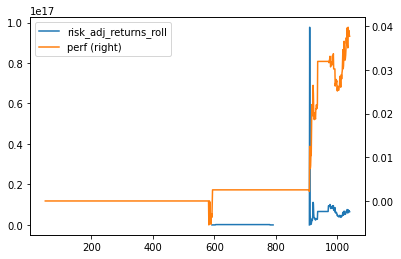

In [26]:
symbol = 'HUM'
_stats = _strategy_lookup[symbol].stat_historical

_stats[['risk_adj_returns_roll', 'perf']].plot(use_index=False, secondary_y=['perf'])


<AxesSubplot:>

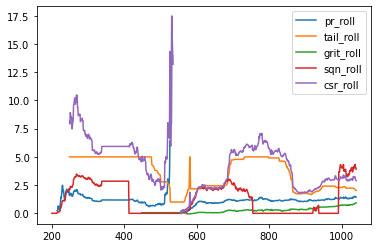

In [25]:
plot_copy = _stats[['pr_roll', 'tail_roll', 'grit_roll', 'sqn_roll', 'csr_roll']]
plot_copy.plot(use_index=False)

<AxesSubplot:title={'center':'MRNA'}>

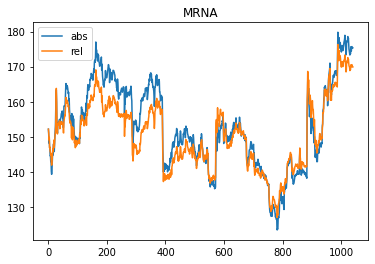

In [17]:
# base = 90
# for i in range(10):
#     quick_plot(base+i)
import src.utils.regime as sur
_symbol_data = _price_data_by_symbol.data[symbol]
_abs_rel_close = pd.DataFrame(
    data={
        'abs': _symbol_data.close,
        'rel': sur.simple_relative(_symbol_data, _bench.close).close
    }
)
_abs_rel_close.plot(title=symbol, use_index=False)

<AxesSubplot:>

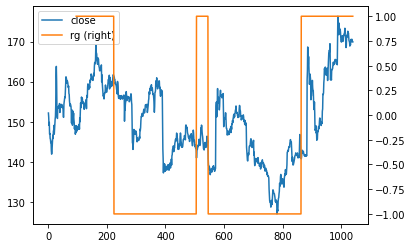

In [18]:
_strategy_lookup[symbol].enhanced_price_data[['close', 'rg']].plot(use_index=False, secondary_y='rg')
